In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install torch torchvision opencv-python albumentations matplotlib scikit-learn tqdm pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 23.3 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20
Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import pandas as pd

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [12]:
class RiverDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # List all files
        image_files = sorted(os.listdir(img_dir))
        mask_files = sorted(os.listdir(mask_dir))
        
        # Get all valid image files
        self.images = []
        self.masks = []
        
        for img_name in image_files:
            if img_name.endswith('.jpg'):
                mask_name = img_name.rsplit('.', 1)[0] + '.png'
                mask_path = os.path.join(mask_dir, mask_name)
                
                if os.path.isfile(mask_path):
                    self.images.append(img_name)
                    self.masks.append(mask_name)
        
        print(f"Found {len(self.images)} valid image-mask pairs")
        if len(self.images) == 0:
            raise ValueError(f"No valid image-mask pairs found!")

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = self.masks[idx]
        
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert mask to float and normalize
        mask = mask.clone().detach().float().unsqueeze(0) / 255.0
        return image, mask

In [13]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use MobileNetV3 with weights parameter instead of pretrained
        self.backbone = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
        
        # Remove classifier and get features only
        self.backbone = self.backbone.features
        
        # Modified decoder to match feature dimensions
        self.decoder = nn.Sequential(
            # Starting from 960 channels at 7x7
            nn.ConvTranspose2d(960, 512, kernel_size=2, stride=2),  # 14x14
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 28x28
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 56x56
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # 112x112
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),    # 224x224
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 1, kernel_size=1),  # 224x224
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Get features from backbone
        features = self.backbone(x)
        # Decode to get segmentation mask
        output = self.decoder(features)
        return output

In [14]:
# Define transforms
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [15]:
# Set up paths and create datasets
base_dir = '/kaggle/input/river-water-segmentation-dataset/riwa_v2'
train_img_dir = os.path.join(base_dir, 'images')
train_mask_dir = os.path.join(base_dir, 'masks')
val_img_dir = os.path.join(base_dir, 'validation', 'images')
val_mask_dir = os.path.join(base_dir, 'validation', 'masks')

In [16]:
# Create datasets
train_dataset = RiverDataset(train_img_dir, train_mask_dir, transform=train_transform)
val_dataset = RiverDataset(val_img_dir, val_mask_dir, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Found 1027 valid image-mask pairs
Found 153 valid image-mask pairs
Training samples: 1027
Validation samples: 153


In [17]:
# Create and initialize model
model = SegmentationModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Test forward pass
test_input = torch.randn(1, 3, 224, 224).to(device)
test_output = model(test_input)
print(f"Test output shape: {test_output.shape}")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 141MB/s] 


Test output shape: torch.Size([1, 1, 224, 224])


In [19]:
# Training loop
num_epochs = 120
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/120: 100%|██████████| 65/65 [00:13<00:00,  4.66it/s]


Epoch 1: Train Loss = 0.3493, Val Loss = 0.3374


Epoch 2/120: 100%|██████████| 65/65 [00:12<00:00,  5.00it/s]


Epoch 2: Train Loss = 0.3316, Val Loss = 0.3203


Epoch 3/120: 100%|██████████| 65/65 [00:13<00:00,  4.88it/s]


Epoch 3: Train Loss = 0.3064, Val Loss = 0.3036


Epoch 4/120: 100%|██████████| 65/65 [00:12<00:00,  5.16it/s]


Epoch 4: Train Loss = 0.2961, Val Loss = 0.2859


Epoch 5/120: 100%|██████████| 65/65 [00:12<00:00,  5.05it/s]


Epoch 5: Train Loss = 0.2750, Val Loss = 0.2826


Epoch 6/120: 100%|██████████| 65/65 [00:12<00:00,  5.04it/s]


Epoch 6: Train Loss = 0.2618, Val Loss = 0.2603


Epoch 7/120: 100%|██████████| 65/65 [00:12<00:00,  5.20it/s]


Epoch 7: Train Loss = 0.2583, Val Loss = 0.2583


Epoch 8/120: 100%|██████████| 65/65 [00:13<00:00,  4.88it/s]


Epoch 8: Train Loss = 0.2370, Val Loss = 0.2596


Epoch 9/120: 100%|██████████| 65/65 [00:12<00:00,  5.04it/s]


Epoch 9: Train Loss = 0.2272, Val Loss = 0.2417


Epoch 10/120: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]


Epoch 10: Train Loss = 0.2163, Val Loss = 0.2378


Epoch 11/120: 100%|██████████| 65/65 [00:12<00:00,  5.12it/s]


Epoch 11: Train Loss = 0.2093, Val Loss = 0.2316


Epoch 12/120: 100%|██████████| 65/65 [00:13<00:00,  4.83it/s]


Epoch 12: Train Loss = 0.1942, Val Loss = 0.2239


Epoch 13/120: 100%|██████████| 65/65 [00:13<00:00,  4.99it/s]


Epoch 13: Train Loss = 0.1860, Val Loss = 0.2177


Epoch 14/120: 100%|██████████| 65/65 [00:13<00:00,  4.81it/s]


Epoch 14: Train Loss = 0.1868, Val Loss = 0.2189


Epoch 15/120: 100%|██████████| 65/65 [00:13<00:00,  4.90it/s]


Epoch 15: Train Loss = 0.1819, Val Loss = 0.2164


Epoch 16/120: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]


Epoch 16: Train Loss = 0.1754, Val Loss = 0.2108


Epoch 17/120: 100%|██████████| 65/65 [00:13<00:00,  4.88it/s]


Epoch 17: Train Loss = 0.1672, Val Loss = 0.2095


Epoch 18/120: 100%|██████████| 65/65 [00:13<00:00,  4.99it/s]


Epoch 18: Train Loss = 0.1607, Val Loss = 0.2053


Epoch 19/120: 100%|██████████| 65/65 [00:12<00:00,  5.08it/s]


Epoch 19: Train Loss = 0.1649, Val Loss = 0.2029


Epoch 20/120: 100%|██████████| 65/65 [00:13<00:00,  4.95it/s]


Epoch 20: Train Loss = 0.1598, Val Loss = 0.2083


Epoch 21/120: 100%|██████████| 65/65 [00:12<00:00,  5.05it/s]


Epoch 21: Train Loss = 0.1485, Val Loss = 0.2014


Epoch 22/120: 100%|██████████| 65/65 [00:13<00:00,  4.95it/s]


Epoch 22: Train Loss = 0.1435, Val Loss = 0.2073


Epoch 23/120: 100%|██████████| 65/65 [00:13<00:00,  4.99it/s]


Epoch 23: Train Loss = 0.1391, Val Loss = 0.1965


Epoch 24/120: 100%|██████████| 65/65 [00:12<00:00,  5.09it/s]


Epoch 24: Train Loss = 0.1350, Val Loss = 0.1949


Epoch 25/120: 100%|██████████| 65/65 [00:12<00:00,  5.06it/s]


Epoch 25: Train Loss = 0.1337, Val Loss = 0.1810


Epoch 26/120: 100%|██████████| 65/65 [00:12<00:00,  5.08it/s]


Epoch 26: Train Loss = 0.1295, Val Loss = 0.1919


Epoch 27/120: 100%|██████████| 65/65 [00:13<00:00,  4.98it/s]


Epoch 27: Train Loss = 0.1280, Val Loss = 0.1845


Epoch 28/120: 100%|██████████| 65/65 [00:12<00:00,  5.08it/s]


Epoch 28: Train Loss = 0.1245, Val Loss = 0.1836


Epoch 29/120: 100%|██████████| 65/65 [00:13<00:00,  4.87it/s]


Epoch 29: Train Loss = 0.1200, Val Loss = 0.1852


Epoch 30/120: 100%|██████████| 65/65 [00:13<00:00,  5.00it/s]


Epoch 30: Train Loss = 0.1162, Val Loss = 0.1832


Epoch 31/120: 100%|██████████| 65/65 [00:12<00:00,  5.06it/s]


Epoch 31: Train Loss = 0.1147, Val Loss = 0.1941


Epoch 32/120: 100%|██████████| 65/65 [00:12<00:00,  5.07it/s]


Epoch 32: Train Loss = 0.1134, Val Loss = 0.1984


Epoch 33/120: 100%|██████████| 65/65 [00:13<00:00,  5.00it/s]


Epoch 33: Train Loss = 0.1164, Val Loss = 0.1872


Epoch 34/120: 100%|██████████| 65/65 [00:12<00:00,  5.06it/s]


Epoch 34: Train Loss = 0.1106, Val Loss = 0.1880


Epoch 35/120: 100%|██████████| 65/65 [00:12<00:00,  5.07it/s]


Epoch 35: Train Loss = 0.1081, Val Loss = 0.1843


Epoch 36/120: 100%|██████████| 65/65 [00:12<00:00,  5.22it/s]


Epoch 36: Train Loss = 0.1051, Val Loss = 0.1917


Epoch 37/120: 100%|██████████| 65/65 [00:12<00:00,  5.03it/s]


Epoch 37: Train Loss = 0.1094, Val Loss = 0.1871


Epoch 38/120: 100%|██████████| 65/65 [00:12<00:00,  5.14it/s]


Epoch 38: Train Loss = 0.1025, Val Loss = 0.1852


Epoch 39/120: 100%|██████████| 65/65 [00:12<00:00,  5.19it/s]


Epoch 39: Train Loss = 0.1015, Val Loss = 0.1822


Epoch 40/120: 100%|██████████| 65/65 [00:12<00:00,  5.05it/s]


Epoch 40: Train Loss = 0.1018, Val Loss = 0.1787


Epoch 41/120: 100%|██████████| 65/65 [00:12<00:00,  5.04it/s]


Epoch 41: Train Loss = 0.0952, Val Loss = 0.1844


Epoch 42/120: 100%|██████████| 65/65 [00:13<00:00,  4.95it/s]


Epoch 42: Train Loss = 0.0926, Val Loss = 0.1845


Epoch 43/120: 100%|██████████| 65/65 [00:12<00:00,  5.10it/s]


Epoch 43: Train Loss = 0.0895, Val Loss = 0.1898


Epoch 44/120: 100%|██████████| 65/65 [00:13<00:00,  4.98it/s]


Epoch 44: Train Loss = 0.0909, Val Loss = 0.1890


Epoch 45/120: 100%|██████████| 65/65 [00:12<00:00,  5.15it/s]


Epoch 45: Train Loss = 0.0932, Val Loss = 0.1877


Epoch 46/120: 100%|██████████| 65/65 [00:13<00:00,  4.99it/s]


Epoch 46: Train Loss = 0.0951, Val Loss = 0.1832


Epoch 47/120: 100%|██████████| 65/65 [00:12<00:00,  5.14it/s]


Epoch 47: Train Loss = 0.0890, Val Loss = 0.1789


Epoch 48/120: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]


Epoch 48: Train Loss = 0.0899, Val Loss = 0.1863


Epoch 49/120: 100%|██████████| 65/65 [00:13<00:00,  4.96it/s]


Epoch 49: Train Loss = 0.0905, Val Loss = 0.1793


Epoch 50/120: 100%|██████████| 65/65 [00:13<00:00,  4.86it/s]


Epoch 50: Train Loss = 0.0853, Val Loss = 0.1779


Epoch 51/120: 100%|██████████| 65/65 [00:12<00:00,  5.08it/s]


Epoch 51: Train Loss = 0.0828, Val Loss = 0.1753


Epoch 52/120: 100%|██████████| 65/65 [00:13<00:00,  5.00it/s]


Epoch 52: Train Loss = 0.0793, Val Loss = 0.1836


Epoch 53/120: 100%|██████████| 65/65 [00:12<00:00,  5.00it/s]


Epoch 53: Train Loss = 0.0777, Val Loss = 0.1891


Epoch 54/120: 100%|██████████| 65/65 [00:12<00:00,  5.02it/s]


Epoch 54: Train Loss = 0.0847, Val Loss = 0.1750


Epoch 55/120: 100%|██████████| 65/65 [00:12<00:00,  5.07it/s]


Epoch 55: Train Loss = 0.0830, Val Loss = 0.1760


Epoch 56/120: 100%|██████████| 65/65 [00:12<00:00,  5.14it/s]


Epoch 56: Train Loss = 0.0775, Val Loss = 0.1828


Epoch 57/120: 100%|██████████| 65/65 [00:12<00:00,  5.05it/s]


Epoch 57: Train Loss = 0.0783, Val Loss = 0.1765


Epoch 58/120: 100%|██████████| 65/65 [00:12<00:00,  5.09it/s]


Epoch 58: Train Loss = 0.0748, Val Loss = 0.1778


Epoch 59/120: 100%|██████████| 65/65 [00:12<00:00,  5.02it/s]


Epoch 59: Train Loss = 0.0749, Val Loss = 0.1787


Epoch 60/120: 100%|██████████| 65/65 [00:12<00:00,  5.06it/s]


Epoch 60: Train Loss = 0.0732, Val Loss = 0.1870


Epoch 61/120: 100%|██████████| 65/65 [00:12<00:00,  5.00it/s]


Epoch 61: Train Loss = 0.0788, Val Loss = 0.1849


Epoch 62/120: 100%|██████████| 65/65 [00:12<00:00,  5.16it/s]


Epoch 62: Train Loss = 0.0826, Val Loss = 0.1824


Epoch 63/120: 100%|██████████| 65/65 [00:12<00:00,  5.00it/s]


Epoch 63: Train Loss = 0.0810, Val Loss = 0.1847


Epoch 64/120: 100%|██████████| 65/65 [00:12<00:00,  5.10it/s]


Epoch 64: Train Loss = 0.0841, Val Loss = 0.1721


Epoch 65/120: 100%|██████████| 65/65 [00:13<00:00,  4.91it/s]


Epoch 65: Train Loss = 0.0766, Val Loss = 0.1778


Epoch 66/120: 100%|██████████| 65/65 [00:12<00:00,  5.05it/s]


Epoch 66: Train Loss = 0.0728, Val Loss = 0.1678


Epoch 67/120: 100%|██████████| 65/65 [00:12<00:00,  5.02it/s]


Epoch 67: Train Loss = 0.0703, Val Loss = 0.1751


Epoch 68/120: 100%|██████████| 65/65 [00:12<00:00,  5.08it/s]


Epoch 68: Train Loss = 0.0713, Val Loss = 0.1765


Epoch 69/120: 100%|██████████| 65/65 [00:12<00:00,  5.00it/s]


Epoch 69: Train Loss = 0.0686, Val Loss = 0.1794


Epoch 70/120: 100%|██████████| 65/65 [00:12<00:00,  5.03it/s]


Epoch 70: Train Loss = 0.0655, Val Loss = 0.1700


Epoch 71/120: 100%|██████████| 65/65 [00:12<00:00,  5.09it/s]


Epoch 71: Train Loss = 0.0756, Val Loss = 0.1764


Epoch 72/120: 100%|██████████| 65/65 [00:12<00:00,  5.16it/s]


Epoch 72: Train Loss = 0.0804, Val Loss = 0.1711


Epoch 73/120: 100%|██████████| 65/65 [00:12<00:00,  5.14it/s]


Epoch 73: Train Loss = 0.0703, Val Loss = 0.1714


Epoch 74/120: 100%|██████████| 65/65 [00:13<00:00,  4.94it/s]


Epoch 74: Train Loss = 0.0675, Val Loss = 0.1787


Epoch 75/120: 100%|██████████| 65/65 [00:12<00:00,  5.17it/s]


Epoch 75: Train Loss = 0.0648, Val Loss = 0.1768


Epoch 76/120: 100%|██████████| 65/65 [00:12<00:00,  5.03it/s]


Epoch 76: Train Loss = 0.0637, Val Loss = 0.1841


Epoch 77/120: 100%|██████████| 65/65 [00:12<00:00,  5.10it/s]


Epoch 77: Train Loss = 0.0635, Val Loss = 0.1764


Epoch 78/120: 100%|██████████| 65/65 [00:12<00:00,  5.02it/s]


Epoch 78: Train Loss = 0.0638, Val Loss = 0.1828


Epoch 79/120: 100%|██████████| 65/65 [00:12<00:00,  5.21it/s]


Epoch 79: Train Loss = 0.0616, Val Loss = 0.1788


Epoch 80/120: 100%|██████████| 65/65 [00:12<00:00,  5.02it/s]


Epoch 80: Train Loss = 0.0638, Val Loss = 0.1762


Epoch 81/120: 100%|██████████| 65/65 [00:12<00:00,  5.05it/s]


Epoch 81: Train Loss = 0.0600, Val Loss = 0.1854


Epoch 82/120: 100%|██████████| 65/65 [00:12<00:00,  5.00it/s]


Epoch 82: Train Loss = 0.0604, Val Loss = 0.1848


Epoch 83/120: 100%|██████████| 65/65 [00:12<00:00,  5.20it/s]


Epoch 83: Train Loss = 0.0606, Val Loss = 0.1851


Epoch 84/120: 100%|██████████| 65/65 [00:12<00:00,  5.15it/s]


Epoch 84: Train Loss = 0.0609, Val Loss = 0.1901


Epoch 85/120: 100%|██████████| 65/65 [00:12<00:00,  5.06it/s]


Epoch 85: Train Loss = 0.0628, Val Loss = 0.1768


Epoch 86/120: 100%|██████████| 65/65 [00:12<00:00,  5.02it/s]


Epoch 86: Train Loss = 0.0612, Val Loss = 0.1815


Epoch 87/120: 100%|██████████| 65/65 [00:12<00:00,  5.09it/s]


Epoch 87: Train Loss = 0.0576, Val Loss = 0.1850


Epoch 88/120: 100%|██████████| 65/65 [00:12<00:00,  5.12it/s]


Epoch 88: Train Loss = 0.0599, Val Loss = 0.1768


Epoch 89/120: 100%|██████████| 65/65 [00:13<00:00,  4.97it/s]


Epoch 89: Train Loss = 0.0588, Val Loss = 0.1882


Epoch 90/120: 100%|██████████| 65/65 [00:12<00:00,  5.09it/s]


Epoch 90: Train Loss = 0.0583, Val Loss = 0.1883


Epoch 91/120: 100%|██████████| 65/65 [00:13<00:00,  4.99it/s]


Epoch 91: Train Loss = 0.0586, Val Loss = 0.2010


Epoch 92/120: 100%|██████████| 65/65 [00:12<00:00,  5.12it/s]


Epoch 92: Train Loss = 0.0608, Val Loss = 0.1971


Epoch 93/120: 100%|██████████| 65/65 [00:13<00:00,  4.85it/s]


Epoch 93: Train Loss = 0.0627, Val Loss = 0.1981


Epoch 94/120: 100%|██████████| 65/65 [00:12<00:00,  5.06it/s]


Epoch 94: Train Loss = 0.0585, Val Loss = 0.1903


Epoch 95/120: 100%|██████████| 65/65 [00:13<00:00,  4.96it/s]


Epoch 95: Train Loss = 0.0551, Val Loss = 0.1975


Epoch 96/120: 100%|██████████| 65/65 [00:12<00:00,  5.11it/s]


Epoch 96: Train Loss = 0.0568, Val Loss = 0.2030


Epoch 97/120: 100%|██████████| 65/65 [00:13<00:00,  4.97it/s]


Epoch 97: Train Loss = 0.0574, Val Loss = 0.1967


Epoch 98/120: 100%|██████████| 65/65 [00:12<00:00,  5.13it/s]


Epoch 98: Train Loss = 0.0560, Val Loss = 0.1993


Epoch 99/120: 100%|██████████| 65/65 [00:12<00:00,  5.04it/s]


Epoch 99: Train Loss = 0.0546, Val Loss = 0.1928


Epoch 100/120: 100%|██████████| 65/65 [00:12<00:00,  5.14it/s]


Epoch 100: Train Loss = 0.0781, Val Loss = 0.2080


Epoch 101/120: 100%|██████████| 65/65 [00:12<00:00,  5.08it/s]


Epoch 101: Train Loss = 0.0658, Val Loss = 0.1822


Epoch 102/120: 100%|██████████| 65/65 [00:12<00:00,  5.07it/s]


Epoch 102: Train Loss = 0.0592, Val Loss = 0.1826


Epoch 103/120: 100%|██████████| 65/65 [00:12<00:00,  5.14it/s]


Epoch 103: Train Loss = 0.0568, Val Loss = 0.1843


Epoch 104/120: 100%|██████████| 65/65 [00:13<00:00,  4.99it/s]


Epoch 104: Train Loss = 0.0585, Val Loss = 0.1877


Epoch 105/120: 100%|██████████| 65/65 [00:12<00:00,  5.06it/s]


Epoch 105: Train Loss = 0.0602, Val Loss = 0.1925


Epoch 106/120: 100%|██████████| 65/65 [00:13<00:00,  4.99it/s]


Epoch 106: Train Loss = 0.0528, Val Loss = 0.1920


Epoch 107/120: 100%|██████████| 65/65 [00:12<00:00,  5.16it/s]


Epoch 107: Train Loss = 0.0521, Val Loss = 0.1953


Epoch 108/120: 100%|██████████| 65/65 [00:13<00:00,  4.98it/s]


Epoch 108: Train Loss = 0.0530, Val Loss = 0.2039


Epoch 109/120: 100%|██████████| 65/65 [00:12<00:00,  5.07it/s]


Epoch 109: Train Loss = 0.0528, Val Loss = 0.2029


Epoch 110/120: 100%|██████████| 65/65 [00:13<00:00,  4.92it/s]


Epoch 110: Train Loss = 0.0522, Val Loss = 0.2065


Epoch 111/120: 100%|██████████| 65/65 [00:12<00:00,  5.25it/s]


Epoch 111: Train Loss = 0.0524, Val Loss = 0.2139


Epoch 112/120: 100%|██████████| 65/65 [00:13<00:00,  4.96it/s]


Epoch 112: Train Loss = 0.0507, Val Loss = 0.2133


Epoch 113/120: 100%|██████████| 65/65 [00:12<00:00,  5.14it/s]


Epoch 113: Train Loss = 0.0523, Val Loss = 0.1963


Epoch 114/120: 100%|██████████| 65/65 [00:12<00:00,  5.03it/s]


Epoch 114: Train Loss = 0.0519, Val Loss = 0.1929


Epoch 115/120: 100%|██████████| 65/65 [00:12<00:00,  5.10it/s]


Epoch 115: Train Loss = 0.0513, Val Loss = 0.2110


Epoch 116/120: 100%|██████████| 65/65 [00:12<00:00,  5.14it/s]


Epoch 116: Train Loss = 0.0501, Val Loss = 0.2045


Epoch 117/120: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]


Epoch 117: Train Loss = 0.0497, Val Loss = 0.2085


Epoch 118/120: 100%|██████████| 65/65 [00:12<00:00,  5.13it/s]


Epoch 118: Train Loss = 0.0503, Val Loss = 0.2056


Epoch 119/120: 100%|██████████| 65/65 [00:12<00:00,  5.01it/s]


Epoch 119: Train Loss = 0.0485, Val Loss = 0.1966


Epoch 120/120: 100%|██████████| 65/65 [00:12<00:00,  5.09it/s]


Epoch 120: Train Loss = 0.0500, Val Loss = 0.2042


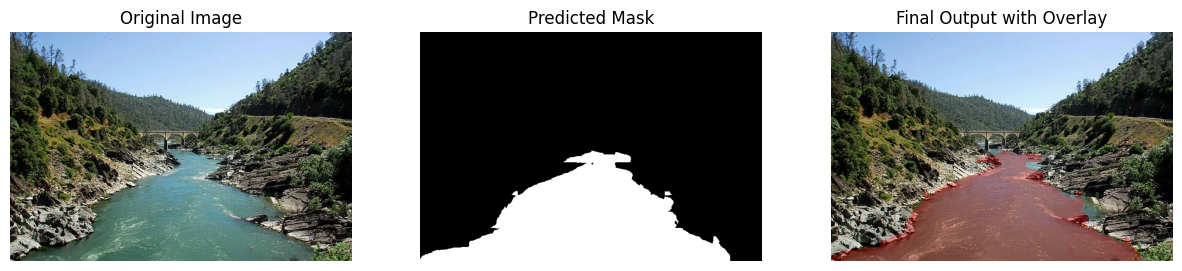

In [20]:
import cv2
import numpy as np
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

def process_image(model, image_path="/kaggle/input/test-image-river/american-river.webp"):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"❌ Could not open image file: {image_path}")

    # Convert BGR to RGB for correct visualization
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define transformation (Resize & Normalize)
    transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # Apply transformation
    transformed = transform(image=rgb_image)
    input_tensor = transformed['image'].unsqueeze(0).to(device)

    # Run model inference
    model.eval()
    with torch.no_grad():
        pred_mask = model(input_tensor)

    # Process the predicted mask
    pred_mask = pred_mask.squeeze().cpu().numpy()
    pred_mask = cv2.resize(pred_mask, (image.shape[1], image.shape[0]))  # Resize back to original
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255  # Threshold & scale

    # Create overlay
    overlay = image.copy()
    overlay[pred_mask > 0] = [0, 0, 255]  # Apply red overlay for segmented region
    output = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)

    # Display results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(rgb_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(pred_mask, cmap="gray")
    ax[1].set_title("Predicted Mask")
    ax[1].axis("off")

    ax[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    ax[2].set_title("Final Output with Overlay")
    ax[2].axis("off")

    plt.show()

# Call the function to process and display your image
process_image(model, "/kaggle/input/test-image-river/american-river.webp")


In [22]:

import cv2
import numpy as np
import torch
from torchvision import transforms
import os

# ✅ Ensure model is loaded correctly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ✅ Input and output paths
input_video_path = '/kaggle/input/test-videos-two/DJI_0030.MP4'
output_video_path = '/kaggle/working/output_segmented_video.mp4'

# ✅ Open video
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    raise ValueError(f"❌ Could not open video file: {input_video_path}")

# ✅ Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30  # Default FPS
frame_width = 512
frame_height = 512
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Try 'XVID' if issues arise
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# ✅ PyTorch transforms (added ToTensor)
torch_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ✅ Parameters for erosion and filtering
min_area = 500  # Minimum area to keep regions
kernel_size = 5  # Erosion kernel size

# ✅ Function to apply region filtering based on area
def filter_regions_by_area(binary_mask, min_area):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_mask = np.zeros_like(binary_mask)
    for contour in contours:
        if cv2.contourArea(contour) > min_area:
            cv2.drawContours(filtered_mask, [contour], -1, 255, thickness=cv2.FILLED)
    return filtered_mask

# ✅ Process video frames
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("✅ End of video or error reading frame.")
        break

    # ✅ Resize frame
    resized_frame = cv2.resize(frame, (frame_width, frame_height))

    # ✅ Convert frame to RGB and tensor
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    frame_tensor = torch_transform(rgb_frame).unsqueeze(0).to(device)

    # ✅ Model prediction
    with torch.no_grad():
        mask = model(frame_tensor)[0].squeeze(0).cpu().numpy()  # (512, 512)

    # ✅ Threshold and resize mask
    binary_mask = (mask > 0.8).astype(np.uint8) * 255  # Binary segmentation mask
    binary_mask_resized = cv2.resize(binary_mask, (frame_width, frame_height))

    # ✅ Erosion for noise removal
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    eroded_mask = cv2.erode(binary_mask_resized, kernel, iterations=1)

    # ✅ Region filtering
    filtered_mask = filter_regions_by_area(eroded_mask, min_area)

    # ✅ Convert mask to 3-channel image
    filtered_mask_colored = np.zeros_like(resized_frame)
    filtered_mask_colored[:, :, 2] = filtered_mask  # Apply red channel for segmentation

    # ✅ Overlay mask on frame
    overlayed_frame = cv2.addWeighted(resized_frame, 1, filtered_mask_colored, 0.5, 0)

    # ✅ Write frame
    out.write(overlayed_frame)

    frame_count += 1
    if frame_count % 100 == 0:
        print(f"✅ Processed {frame_count} frames.")

# ✅ Release resources
cap.release()
out.release()

# ✅ Verify output file existence
if os.path.exists(output_video_path):
    print(f"🎥 Processed video saved at: {output_video_path}")
else:
    print(f"❌ Video not saved! Check file path: {output_video_path}")


✅ Processed 100 frames.
✅ Processed 200 frames.
✅ Processed 300 frames.
✅ Processed 400 frames.
✅ Processed 500 frames.
✅ Processed 600 frames.
✅ Processed 700 frames.
✅ Processed 800 frames.
✅ Processed 900 frames.
✅ Processed 1000 frames.
✅ Processed 1100 frames.
✅ Processed 1200 frames.
✅ Processed 1300 frames.
✅ Processed 1400 frames.
✅ Processed 1500 frames.
✅ Processed 1600 frames.
✅ Processed 1700 frames.
✅ Processed 1800 frames.
✅ Processed 1900 frames.
✅ Processed 2000 frames.
✅ Processed 2100 frames.
✅ Processed 2200 frames.
✅ Processed 2300 frames.
✅ Processed 2400 frames.
✅ Processed 2500 frames.
✅ Processed 2600 frames.
✅ Processed 2700 frames.
✅ Processed 2800 frames.
✅ End of video or error reading frame.
🎥 Processed video saved at: /kaggle/working/output_segmented_video.mp4
